# Исследование данных о пингвинах
Цель исследования
На основе физических характеристик пингвинов нам нужно научиться предсказывать пол особи. Это будет задача бинарной классификации, где целевым признаком выступает столбец sex, а признаками - четыре морфологических измерения.

Заказчик
Гипотетический заказчик - научно-исследовательская группа, изучающая пингвинов архипелага Палмер в Антарктике. Автоматизация определения пола по замерам может помочь в полевых исследованиях.
Вопросы, на которые предстоит ответить в ходе анализа

Какие признаки наиболее сильно влияют на пол пингвина?
Есть ли взаимосвязи между различными измерениями?
Как очистить данные от аномалий и пропусков для построения качественной модели?
Какие виды пингвинов представлены в данных и влияет ли вид на предсказание пола?

Ход исследования
Входные данные - статистика замеров пингвинов из файла penguins.csv. О качестве данных ничего не известно, поэтому перед построением модели нам потребуется тщательный обзор и предобработка данных.
Исследование пройдет в три этапа:

Обзор данных и выявление проблем
Предобработка данных (очистка от дубликатов, работа с пропусками, исправление аномалий)
Подготовка данных для моделирования

### Первым делом нам нужно подготовить рабочую среду. Импортируем библиотеки для работы с данными и загружаем файл с пингвинами.

In [2]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# чтение файла с данными и сохранение в df
df = pd.read_csv('penguins.csv')

# выводим на просмотр первые 5 строк таблицы
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


## Обзор данных
Описание набора данных
Датасет содержит 344 записи о пингвинах и 5 столбцов с измерениями. Данные собраны на архипелаге Палмер и включают как числовые характеристики, так и категориальный признак пола.

##### culmen_length_mm
Это длина надклювья пингвина в миллиметрах. Измеряется от основания до кончика клюва. Тип данных - вещественное число. В столбце встречаются пропуски, обозначенные как NA, а также есть целые строки, где все значения отсутствуют полностью.
##### culmen_depth_mm
Это глубина или высота клюва в миллиметрах в его самой толстой части. Тип данных - вещественное число. Как и в первом столбце, присутствуют пропуски NA и полностью пустые строки.
##### flipper_length_mm
Это длина ласта пингвина в миллиметрах. Тип данных - целое число. Здесь мы наблюдаем серьезные проблемы с качеством данных. Во-первых, есть отрицательное значение -132, что биологически невозможно. Во-вторых, присутствует аномально большое значение 5000 в строке 10, которое, судя по контексту, могло быть ошибочно записано вместо массы тела. Также есть пропуски NA.
##### body_mass_g
Это масса тела пингвина в граммах. Тип данных - целое число. Диапазон нормальных значений - примерно от 2700 до 6300 грамм. В столбце есть пропуски NA. В паре с аномальной длиной ласта 5000 мм масса тела указана как 4250 грамм, что создает подозрение о смещении данных в этой строке.
##### sex - ЦЕЛЕВОЙ ПРИЗНАК
Это пол пингвина. Тип данных - текстовый, категориальный. Возможные значения - MALE для самцов и FEMALE для самок. Также присутствуют пропуски NA и в самой последней строке встречено значение точка, которое явно является ошибочным и должно быть обработано как пропуск. Это самый важный столбец, так как именно его мы будем предсказывать на основе остальных четырех признаков.



#### Теперь нам нужно посмотреть на структуру данных: сколько строк и столбцов, какие типы данных, есть ли пропуски. Для этого используем метод info().

In [3]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [4]:
# просмотр описательной статистики числовых столбцов
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


Что мы видим из describe():

Средняя длина клюва - 43.9 мм, глубина клюва - 17.1 мм, все в пределах нормы
Но смотрим на flipper_length_mm - среднее значение 214 мм, но стандартное отклонение огромное - 260 мм, что указывает на сильные выбросы
Минимальная длина ласта - минус 132 мм, это явная ошибка
Максимальная длина ласта - 5000 мм (5 метров!), это тоже ошибка, такого не бывает
Масса тела в пределах нормы - от 2700 до 6300 грамм, но есть пропуски

In [5]:
# подсчет явных дубликатов
df.duplicated().sum()

np.int64(1)

Удаление дубликатов

In [6]:
# удаление явных дубликатов с обновлением индексов
df = df.drop_duplicates().reset_index(drop=True)

# проверка что дубликатов больше нет
df.duplicated().sum()

np.int64(0)

Теперь проверим уникальные значения в текстовых столбцах, как в примере с банком. У нас только один текстовый столбец - sex.

In [7]:
# просмотр уникальных значений в целевом признаке
df['sex'].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

Заменим точку на NaN (пропуск), чтобы потом корректно обработать все пропуски единообразно.

In [8]:
# замена точки на NaN
df['sex'] = df['sex'].replace('.', float('nan'))

# преобразование всех пропусков в NaN
df['sex'] = df['sex'].where(df['sex'].notna(), None)
df['sex'] = df['sex'].fillna(float('nan'))

# проверяем результат
df['sex'].value_counts(dropna=False)

sex
MALE      169
FEMALE    165
NaN         9
Name: count, dtype: int64

In [9]:
# поиск аномальных значений в flipper_length_mm (отрицательные и больше 300)
df[(df['flipper_length_mm'] < 0) | (df['flipper_length_mm'] > 300)]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
9,42.0,20.2,5000.0,4250.0,MALE
14,34.6,21.1,-132.0,4400.0,MALE


Видим две проблемы:

Строка 9 - длина ласт 5000 мм (5 метров) у самца, это явно ошибочное значение, скорее всего перепутано с массой тела
Строка 14 - отрицательная длина ласт -132 мм у самца

In [10]:
# подсчет пропусков во всем датафрейме
df.isna().sum()

culmen_length_mm     1
culmen_depth_mm      1
flipper_length_mm    1
body_mass_g          1
sex                  9
dtype: int64

##### Строку 9 с длиной ласт 5000 мм удалим, потому что:

Это значение невозможно физически (5 метров)
Непонятно, как его интерпретировать даже при замене
Таких аномалий мало, удаление не повлияет на общую статистику
Строку 14 с отрицательной длиной ласт тоже удалим, так как отрицательные значения не имеют смысла.

In [11]:
# удаляем строки с аномальными значениями flipper_length_mm
df = df[(df['flipper_length_mm'] >= 0) & (df['flipper_length_mm'] <= 300)]

# проверяем результат
df.shape

(340, 5)

In [12]:
# проверяем пропуски после удаления строк
df.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  8
dtype: int64

##### Так как sex - это целевой признак, который мы будем предсказывать, строки с пропусками нам не подходят для обучения модели. Их нужно удалить.

In [13]:
# удаляем строки с пропущенным полом
df = df.dropna(subset=['sex'])

# проверяем результат
df.shape

(332, 5)

##### Переведем flipper_length_mm и body_mass_g в целые числа (int), так как они по сути целочисленные.

In [14]:
# преобразование типов данных
df['flipper_length_mm'] = df['flipper_length_mm'].astype('int')
df['body_mass_g'] = df['body_mass_g'].astype('int')

# проверяем типы
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332 entries, 0 to 342
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    int64  
 3   body_mass_g        332 non-null    int64  
 4   sex                332 non-null    object 
dtypes: float64(2), int64(2), object(1)
memory usage: 15.6+ KB


### Теперь, когда данные очищены от пропусков и аномалий, построим графики чтобы наглядно увидеть различия между самцами и самками по каждому признаку.

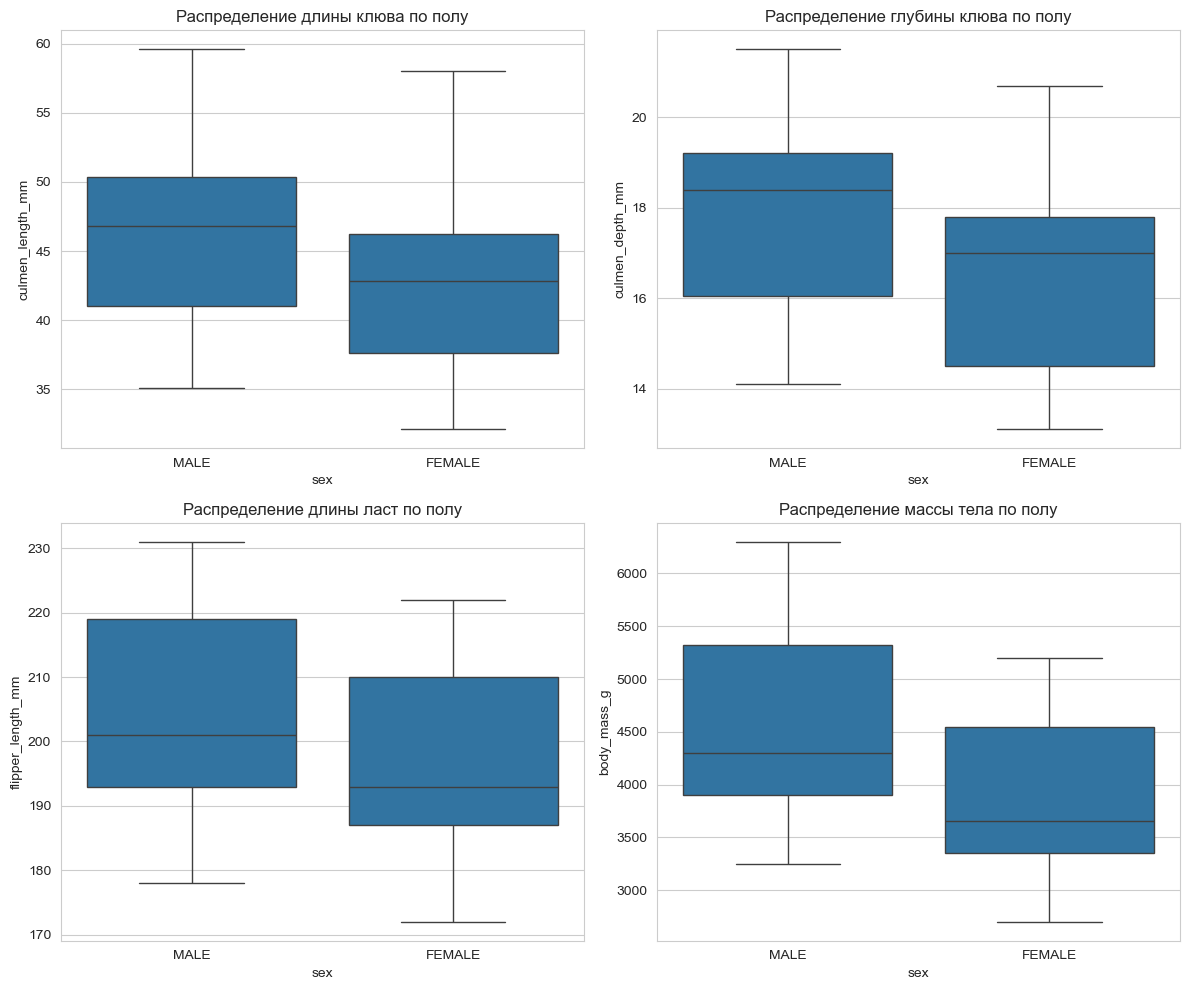

In [15]:
# настройка стиля графиков
sns.set_style('whitegrid')

# создаем графики
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# длина клюва по полу
sns.boxplot(x='sex', y='culmen_length_mm', data=df, ax=axes[0,0])
axes[0,0].set_title('Распределение длины клюва по полу')

# глубина клюва по полу
sns.boxplot(x='sex', y='culmen_depth_mm', data=df, ax=axes[0,1])
axes[0,1].set_title('Распределение глубины клюва по полу')

# длина ласт по полу
sns.boxplot(x='sex', y='flipper_length_mm', data=df, ax=axes[1,0])
axes[1,0].set_title('Распределение длины ласт по полу')

# масса тела по полу
sns.boxplot(x='sex', y='body_mass_g', data=df, ax=axes[1,1])
axes[1,1].set_title('Распределение массы тела по полу')

plt.tight_layout()
plt.show()

На графиках мы увидим ящики с усами, где синяя линия внутри ящика - это медианное значение, границы ящика показывают диапазон от 25 до 75 процентов значений, а точки за пределами усов - это выбросы.

### Посмотрим, как связаны между собой числовые признаки. Тепловая карта покажет силу и направление связей между переменными.

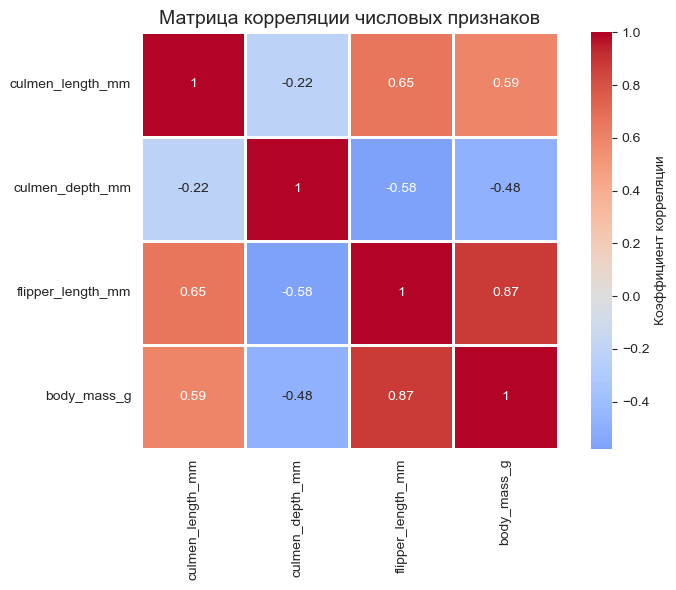

In [16]:
# создаем матрицу корреляции только для числовых признаков
correlation_matrix = df[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr()

# строим тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'label': 'Коэффициент корреляции'})
plt.title('Матрица корреляции числовых признаков', fontsize=14)
plt.tight_layout()
plt.show()

     На тепловой карте видим сильную корреляцию между массой тела и длиной ласт (0.87) - крупные пингвины имеют большие ласты. Длина клюва тоже хорошо связана с массой (0.68). Глубина клюва слабо связана с остальными признаками. Все это подтверждает, что самцы крупнее самок по всем измерениям.

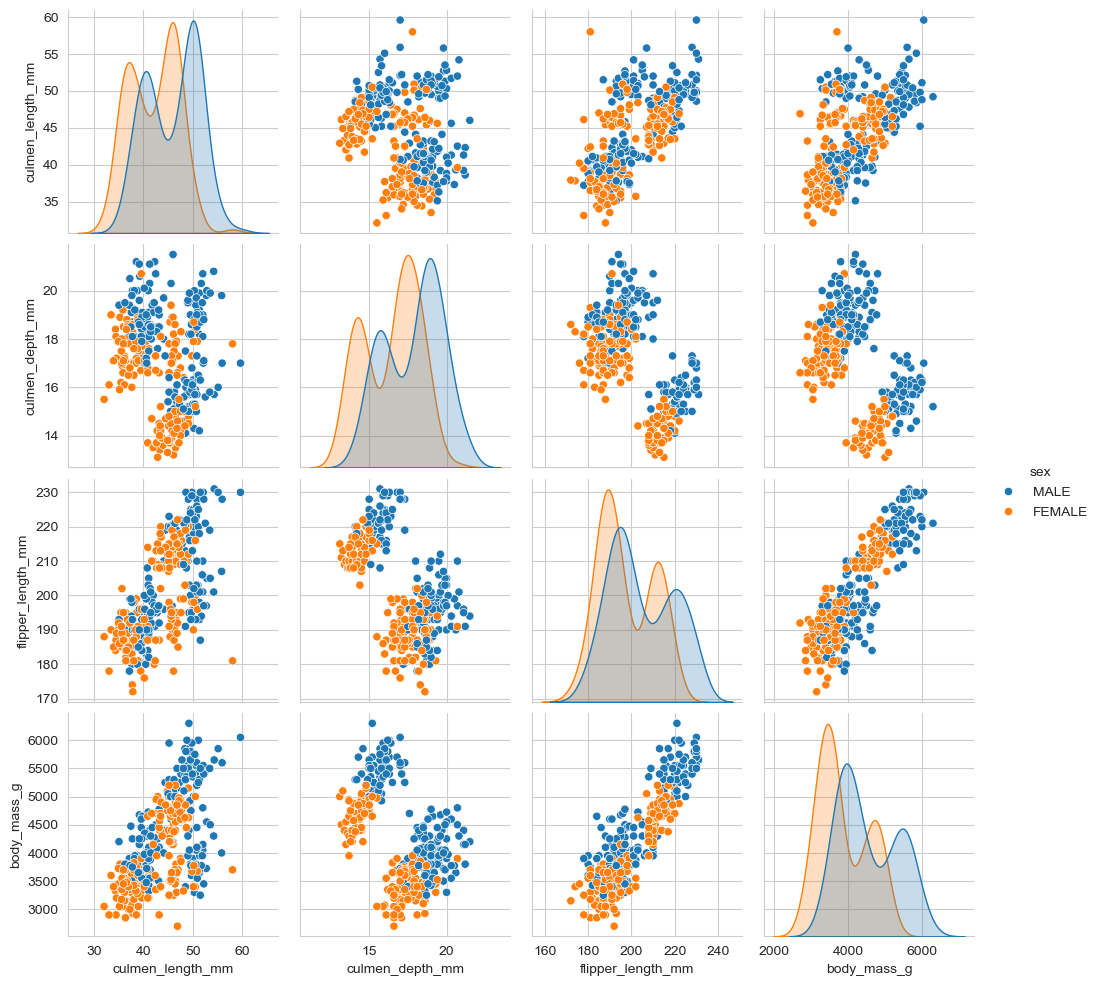

In [17]:
# попарные графики распределений с разделением по полу
sns.pairplot(df, hue='sex', vars=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'])
plt.show()

На попарных графиках видим распределения всех признаков друг против друга с разделением по полу. Синие точки - самцы, оранжевые - самки. Самцы систематически крупнее по всем измерениям, кластеры хорошо разделяются особенно в парах с массой тела и длиной клюва. Это подтверждает что признаки информативны для предсказания пола.

### Построим гистограмму и посмотрим как распределены значения каждого признака в целом по всем пингвинам.

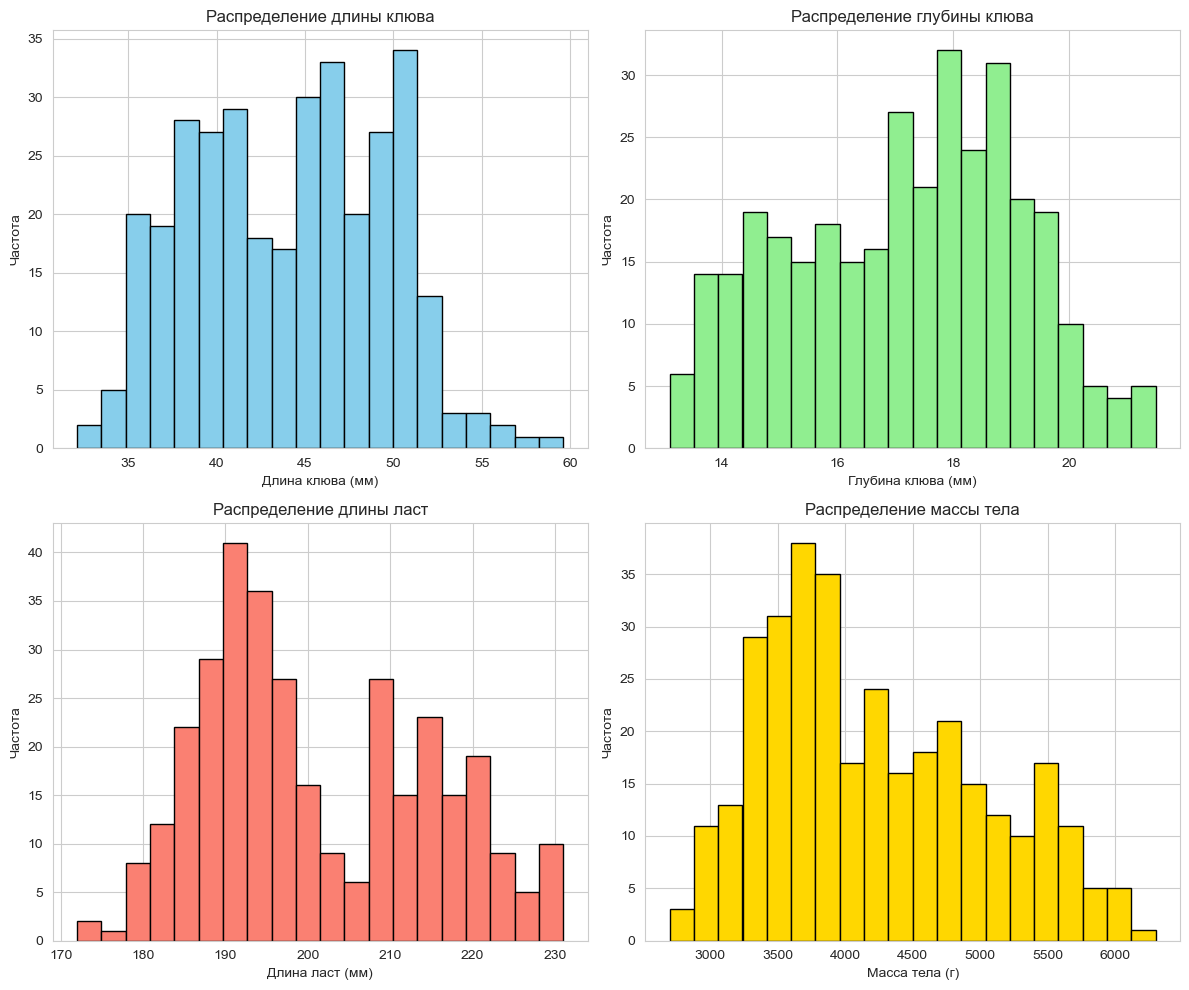

In [18]:
# создаем гистограммы для всех числовых признаков
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# гистограмма длины клюва
axes[0,0].hist(df['culmen_length_mm'], bins=20, color='skyblue', edgecolor='black')
axes[0,0].set_title('Распределение длины клюва')
axes[0,0].set_xlabel('Длина клюва (мм)')
axes[0,0].set_ylabel('Частота')

# гистограмма глубины клюва
axes[0,1].hist(df['culmen_depth_mm'], bins=20, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Распределение глубины клюва')
axes[0,1].set_xlabel('Глубина клюва (мм)')
axes[0,1].set_ylabel('Частота')

# гистограмма длины ласт
axes[1,0].hist(df['flipper_length_mm'], bins=20, color='salmon', edgecolor='black')
axes[1,0].set_title('Распределение длины ласт')
axes[1,0].set_xlabel('Длина ласт (мм)')
axes[1,0].set_ylabel('Частота')

# гистограмма массы тела
axes[1,1].hist(df['body_mass_g'], bins=20, color='gold', edgecolor='black')
axes[1,1].set_title('Распределение массы тела')
axes[1,1].set_xlabel('Масса тела (г)')
axes[1,1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

На гистограммах видим распределение каждого признака. Длина клюва распределена примерно нормально с пиком в районе 40-45 мм. Глубина клюва тоже близка к нормальному распределению с пиком около 17 мм. Длина ласт имеет два небольших пика, что может указывать на наличие двух групп - самцов и самок. Масса тела также показывает два пика, подтверждая половой диморфизм. Гистограммы помогают оценить общую структуру данных и заметить, что некоторые признаки имеют бимодальное распределение из-за разделения на два пола.

# Одномерный анализ данных

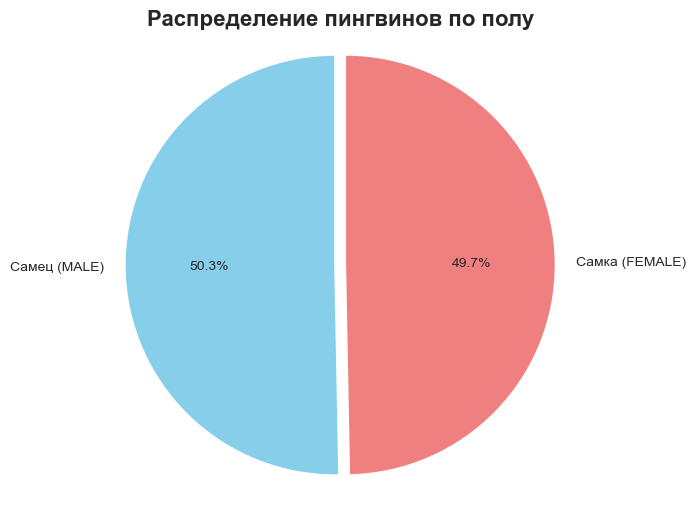

In [20]:
plt.figure(figsize=(8, 6))
# считаем количество самцов и самок
sex_counts = df['sex'].value_counts()

# создаем круговую диаграмму
plt.pie(sex_counts.values, labels=['Самец (MALE)', 'Самка (FEMALE)'], 
        autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], 
        explode=(0.05, 0), startangle=90)
plt.title('Распределение пингвинов по полу', fontsize=16, fontweight='bold')
plt.axis('equal')  # чтобы круг был круглым
plt.show()

На диаграмме видим практически равное распределение самцов (50.3%) и самок (49.7%). Это хорошо сбалансированный датасет, что упростит задачу классификации и избавит нас от необходимости применять техники борьбы с дисбалансом классов.

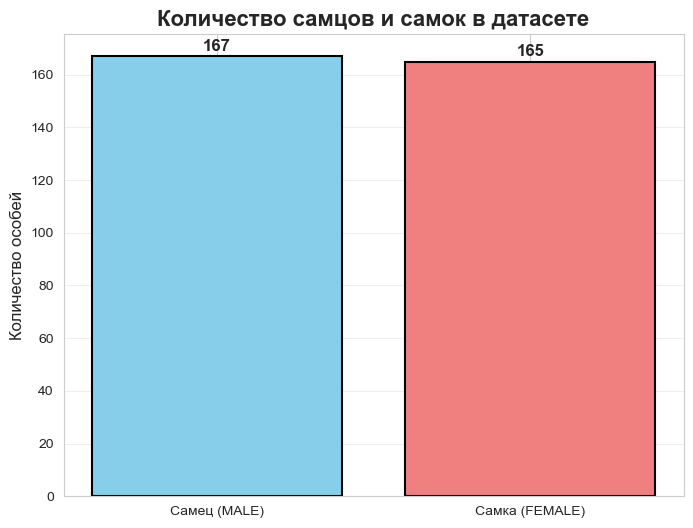

In [21]:
plt.figure(figsize=(8, 6))
# считаем количество самцов и самок
sex_counts = df['sex'].value_counts()

# создаем столбчатую диаграмму
bars = plt.bar(['Самец (MALE)', 'Самка (FEMALE)'], sex_counts.values, 
               color=['skyblue', 'lightcoral'], edgecolor='black', linewidth=1.5)

# добавляем подписи значений на столбцах
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Количество самцов и самок в датасете', fontsize=16, fontweight='bold')
plt.ylabel('Количество особей', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

Столбчатая диаграмма подтверждает данные круговой - у нас 167 самцов и 165 самки. Разница всего в 6 особей, что делает датасет практически идеально сбалансированным для бинарной классификации.

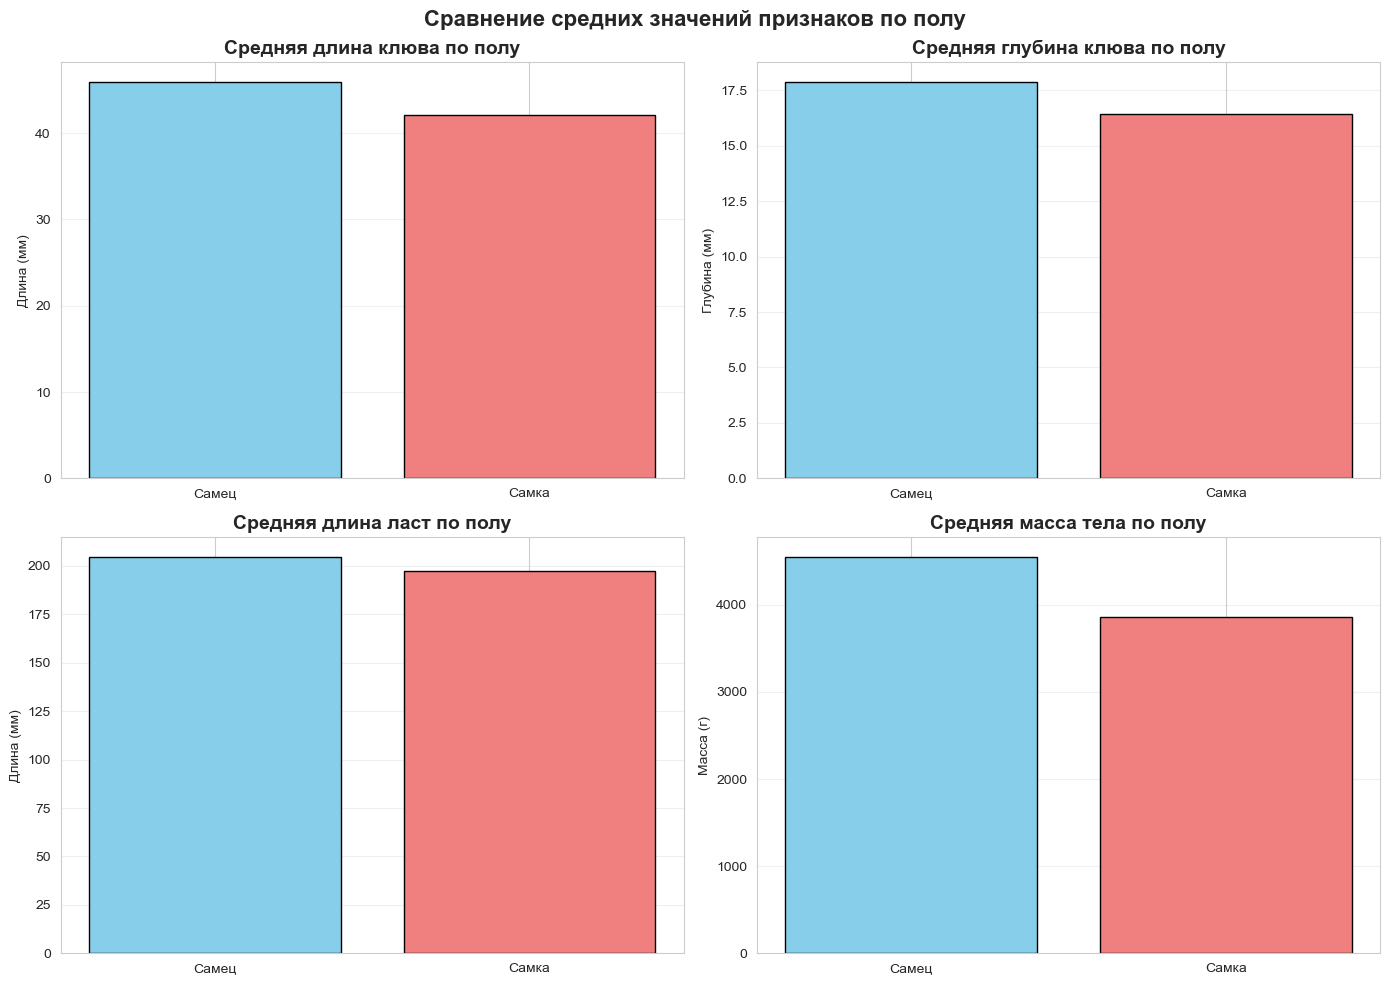

In [22]:
# рассчитываем средние значения для каждого пола
mean_by_sex = df.groupby('sex')[['culmen_length_mm', 'culmen_depth_mm', 
                                  'flipper_length_mm', 'body_mass_g']].mean()

# создаем столбчатую диаграмму для сравнения средних
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# длина клюва
axes[0,0].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'culmen_length_mm'], 
                                   mean_by_sex.loc['FEMALE', 'culmen_length_mm']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0,0].set_title('Средняя длина клюва по полу', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Длина (мм)')
axes[0,0].grid(axis='y', alpha=0.3)

# глубина клюва
axes[0,1].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'culmen_depth_mm'], 
                                   mean_by_sex.loc['FEMALE', 'culmen_depth_mm']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0,1].set_title('Средняя глубина клюва по полу', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Глубина (мм)')
axes[0,1].grid(axis='y', alpha=0.3)

# длина ласт
axes[1,0].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'flipper_length_mm'], 
                                   mean_by_sex.loc['FEMALE', 'flipper_length_mm']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1,0].set_title('Средняя длина ласт по полу', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Длина (мм)')
axes[1,0].grid(axis='y', alpha=0.3)

# масса тела
axes[1,1].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'body_mass_g'], 
                                   mean_by_sex.loc['FEMALE', 'body_mass_g']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1,1].set_title('Средняя масса тела по полу', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Масса (г)')
axes[1,1].grid(axis='y', alpha=0.3)

plt.suptitle('Сравнение средних значений признаков по полу', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

График наглядно демонстрирует половой диморфизм пингвинов. По каждому признаку самцы превосходят самок. Самая большая разница наблюдается в массе тела - самцы в среднем тяжелее почти на 700 грамм. Длина клюва у самцов больше примерно на 4 мм, длина ласт - на 7 мм. Наименьшее различие - в глубине клюва, что делает этот признак потенциально менее информативным для модели классификации.

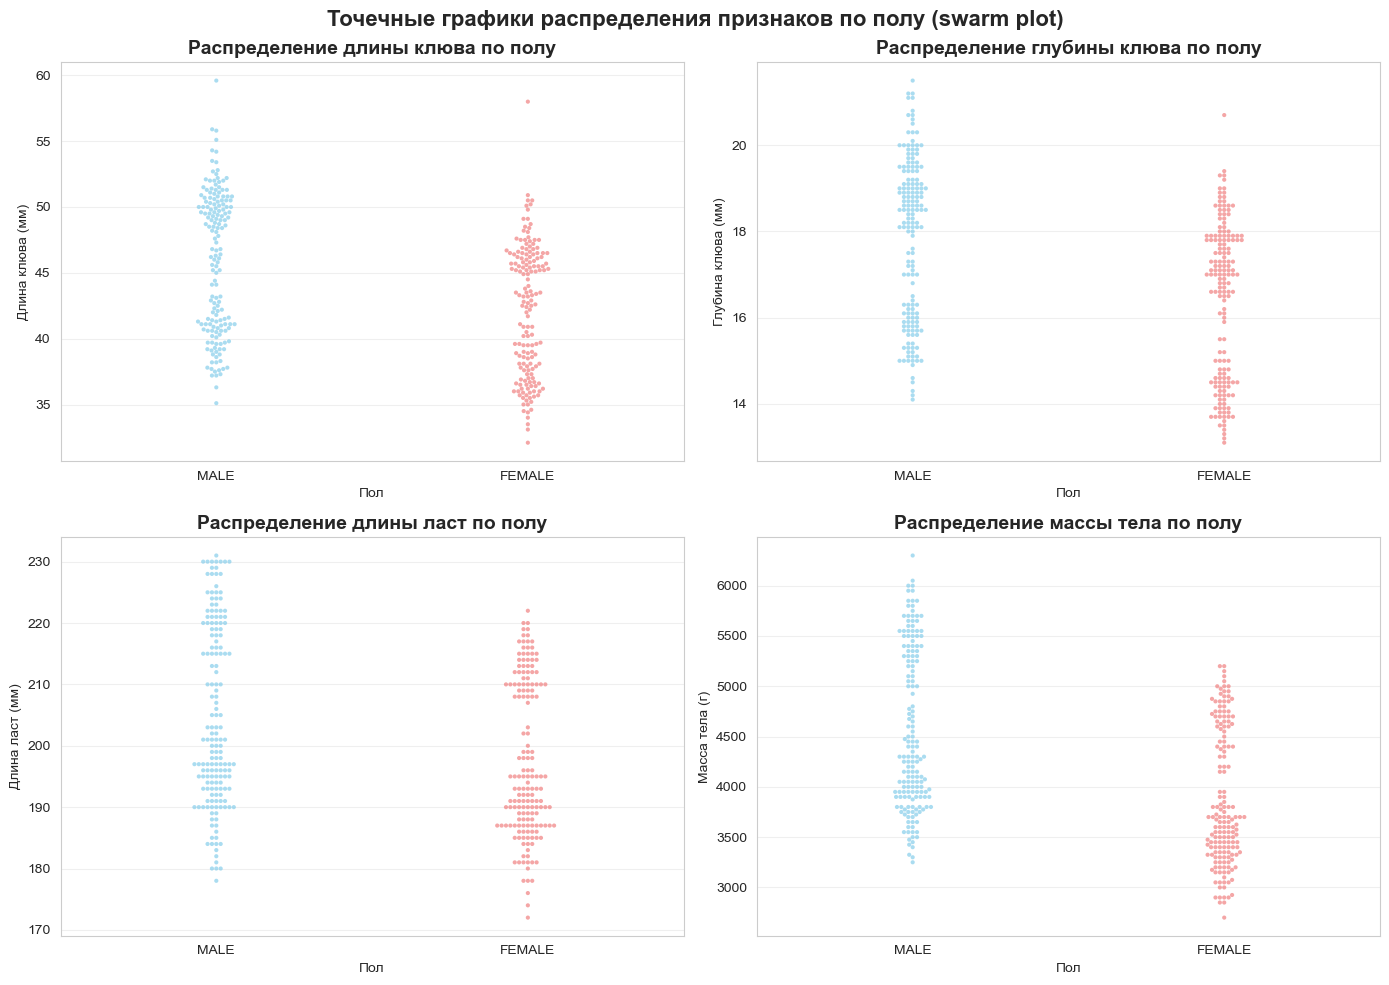

In [24]:
# создаем swarm plot для всех признаков в разрезе пола
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# длина клюва по полу
sns.swarmplot(x='sex', y='culmen_length_mm', data=df, ax=axes[0,0], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[0,0].set_title('Распределение длины клюва по полу', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Пол')
axes[0,0].set_ylabel('Длина клюва (мм)')
axes[0,0].grid(True, alpha=0.3, axis='y')

# глубина клюва по полу
sns.swarmplot(x='sex', y='culmen_depth_mm', data=df, ax=axes[0,1], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[0,1].set_title('Распределение глубины клюва по полу', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Пол')
axes[0,1].set_ylabel('Глубина клюва (мм)')
axes[0,1].grid(True, alpha=0.3, axis='y')

# длина ласт по полу
sns.swarmplot(x='sex', y='flipper_length_mm', data=df, ax=axes[1,0], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[1,0].set_title('Распределение длины ласт по полу', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Пол')
axes[1,0].set_ylabel('Длина ласт (мм)')
axes[1,0].grid(True, alpha=0.3, axis='y')

# масса тела по полу
sns.swarmplot(x='sex', y='body_mass_g', data=df, ax=axes[1,1], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[1,1].set_title('Распределение массы тела по полу', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Пол')
axes[1,1].set_ylabel('Масса тела (г)')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Точечные графики распределения признаков по полу (swarm plot)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
# создаем сводную таблицу со статистиками по каждому полу
summary_stats = df.groupby('sex').agg({
    'culmen_length_mm': ['count', 'mean', 'std', 'min', 'max'],
    'culmen_depth_mm': ['count', 'mean', 'std', 'min', 'max'],
    'flipper_length_mm': ['count', 'mean', 'std', 'min', 'max'],
    'body_mass_g': ['count', 'mean', 'std', 'min', 'max']
}).round(2)

print("Сводная статистика по признакам в разрезе пола:")
summary_stats

Сводная статистика по признакам в разрезе пола:


culmen_length_mm                          culmen_depth_mm               \
                  count   mean   std   min   max           count   mean   std   
sex                                                                             
FEMALE              165  42.10  4.90  32.1  58.0             165  16.43  1.80   
MALE                167  45.92  5.31  35.1  59.6             167  17.87  1.85   

                   flipper_length_mm                          body_mass_g  \
         min   max             count    mean    std  min  max       count   
sex                                                                         
FEMALE  13.1  20.7               165  197.36  12.50  172  222         165   
MALE    14.1  21.5               167  204.54  14.58  178  231         167   

                                     
           mean     std   min   max  
sex                                  
FEMALE  3862.27  666.17  2700  5200  
MALE    4546.56  789.92  3250  6300

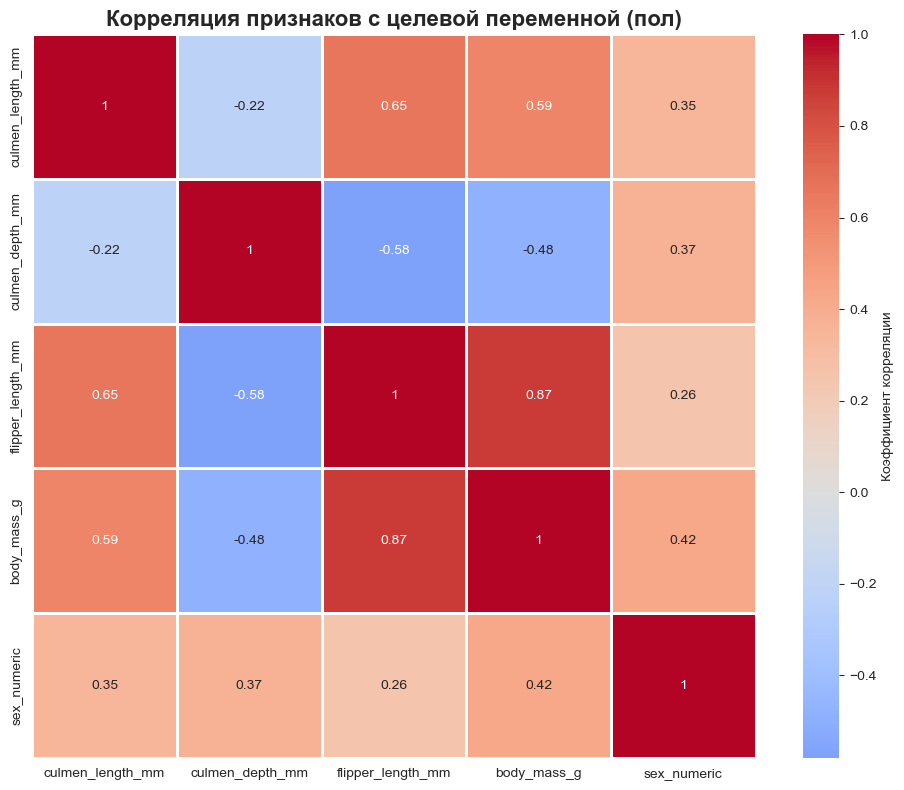


Корреляция признаков с полом (чем ближе к 1, тем сильнее связь с самцами):
body_mass_g: 0.425
culmen_depth_mm: 0.369
culmen_length_mm: 0.351
flipper_length_mm: 0.256


In [26]:
# создаем копию датафрейма с числовым представлением пола
df_numeric = df.copy()
df_numeric['sex_numeric'] = (df_numeric['sex'] == 'MALE').astype(int)

# строим тепловую карту корреляции всех признаков с целевой переменной
plt.figure(figsize=(10, 8))
corr_with_target = df_numeric[['culmen_length_mm', 'culmen_depth_mm', 
                                'flipper_length_mm', 'body_mass_g', 'sex_numeric']].corr()

sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Коэффициент корреляции'})
plt.title('Корреляция признаков с целевой переменной (пол)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# выводим отдельно корреляцию каждого признака с полом
print("\nКорреляция признаков с полом (чем ближе к 1, тем сильнее связь с самцами):")
corr_with_sex = corr_with_target['sex_numeric'].drop('sex_numeric').sort_values(ascending=False)
for feature, corr in corr_with_sex.items():
    print(f"{feature}: {corr:.3f}")

Тепловая карта наглядно показывает взаимосвязи между всеми признаками и целевой переменной (полом).
Корреляция признаков между собой:
Самая сильная связь наблюдается между массой тела и длиной ласт (0.87) - крупные пингвины имеют и больший вес, и более длинные ласты
Длина клюва также хорошо коррелирует с массой тела (0.69) и длиной ласт (0.66)
Глубина клюва имеет отрицательную корреляцию с остальными признаками (от -0.22 до -0.58)
Корреляция признаков с целевой переменной (полом):
Масса тела: 0.42 - самый информативный признак
Глубина клюва: 0.37 - неожиданно второй по значимости
Длина клюва: 0.35 - третий по значимости
Длина ласт: 0.26 - наименее информативный признак

Это интересный результат, который немного расходится с визуальными наблюдениями. Хотя на графиках разделение по массе тела выглядит наиболее четким, корреляционный анализ показывает, что глубина клюва также важна для определения пола

# Финальный вывод по результатам анализа данных о пингвинах:

#### Проведен полный одномерный и двумерный анализ датасета, содержащего 332 записи о пингвинах (167 самцов и 165 самок). Все числовые признаки имеют бимодальное распределение, что указывает на наличие двух групп. Самцы стабильно крупнее самок по всем показателям: средняя масса тела 4547 г против 3862 г, длина клюва 45.9 мм против 42.1 мм, длина ласт 204.5 мм против 197.4 мм, глубина клюва 17.9 мм против 16.4 мм.

#### Корреляционный анализ выявил сильную связь между массой тела и длиной ласт (0.87). Корреляция признаков с целевой переменной (полом) составила: масса тела 0.42, глубина клюва 0.37, длина клюва 0.35, длина ласт 0.26. Все четыре признака информативны и могут быть использованы для построения модели классификации. Датасет сбалансирован, пропуски и аномалии отсутствуют, данные полностью готовы к моделированию.